# COVID‑19 Feature Engineering & Risk Labeling (Cleaned Data)

**Using** `cleaned_usa_covid_data.csv`, which already contains the U.S. subset and any preliminary cleaning.

**Steps**  
1. Load cleaned data  
2. Coerce numeric columns  
3. 7‑day rolling averages (cases, deaths, ICU, hospitalizations)  
4. Daily % changes (cases, deaths)  
5. Composite risk index  
6. Quantile‐based Low/Medium/High labels  
7. Validation plots  
8. Save engineered dataset  


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1. Load the cleaned U.S. COVID dataset from the data folder
us = pd.read_csv('../data/cleaned_usa_covid_data.csv', parse_dates=['date'])
us = us.sort_values('date').reset_index(drop=True)

# 2. Truncate to start at the first non‑zero new_cases date
first_case_date = us.loc[us['new_cases'] > 0, 'date'].min()
us = us[us['date'] >= first_case_date].copy().reset_index(drop=True)
print(f"Data filtered to start at first case: {first_case_date.date()}")

# 3. Quick peek at the beginning of our “non-zero” dataset
display(us.head())
print("\nColumns and dtypes:")
print(us.dtypes)


Data filtered to start at first case: 2020-01-26


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,handwashing_facilities,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,7_day_avg_cases,7_day_avg_deaths
0,USA,North America,United States,2020-01-26,7.0,7.0,1.0,0.0,0.0,0.0,...,NaN,78.86,0.926,338289856,-9018.2,-3.64,-3.02,-26.844515,1.0,0.0
1,USA,North America,United States,2020-01-27,7.0,0.0,1.0,0.0,0.0,0.0,...,NaN,78.86,0.926,338289856,NaN,NaN,NaN,NaN,1.0,0.0
2,USA,North America,United States,2020-01-28,7.0,0.0,1.0,0.0,0.0,0.0,...,NaN,78.86,0.926,338289856,NaN,NaN,NaN,NaN,1.0,0.0
3,USA,North America,United States,2020-01-29,7.0,0.0,1.0,0.0,0.0,0.0,...,NaN,78.86,0.926,338289856,NaN,NaN,NaN,NaN,1.0,0.0
4,USA,North America,United States,2020-01-30,7.0,0.0,1.0,0.0,0.0,0.0,...,NaN,78.86,0.926,338289856,NaN,NaN,NaN,NaN,1.0,0.0



Columns and dtypes:
iso_code                                           object
continent                                          object
location                                           object
date                                       datetime64[ns]
total_cases                                       float64
                                                ...      
excess_mortality_cumulative                       float64
excess_mortality                                  float64
excess_mortality_cumulative_per_million           float64
7_day_avg_cases                                   float64
7_day_avg_deaths                                  float64
Length: 68, dtype: object


In [22]:
# 2. Ensure key columns are numeric (coerce & fill)
for col in ['new_cases','new_deaths','icu_patients','hosp_patients']:
    us[col] = pd.to_numeric(us[col], errors='coerce').fillna(0)

# Confirm
display(us[['date','new_cases','new_deaths','icu_patients','hosp_patients']].head(5))
    

,date,new_cases,new_deaths,icu_patients,hosp_patients
0,2020-01-26,7.0,0.0,0.0,0.0
1,2020-01-27,0.0,0.0,0.0,0.0
2,2020-01-28,0.0,0.0,0.0,0.0
3,2020-01-29,0.0,0.0,0.0,0.0
4,2020-01-30,0.0,0.0,0.0,0.0


# 7-day rolling averages for new cases and new deaths

In [ ]:
# 3. 7‑day rolling averages (min_periods=7)
us['roll_cases']  = us['new_cases'].rolling(window=7,  min_periods=7).mean()
us['roll_deaths'] = us['new_deaths'].rolling(window=7, min_periods=7).mean()
us['roll_icu']    = us['icu_patients'].rolling(window=7, min_periods=7).mean()
us['roll_hosp']   = us['hosp_patients'].rolling(window=7, min_periods=7).mean()

# Show first few non-null
display(
    us.loc[us['roll_cases'].notna(), 
           ['date','new_cases','roll_cases','new_deaths','roll_deaths','icu_patients','roll_icu','hosp_patients','roll_hosp']
          ].head(1000)
)

# compute and display stats for the 7-day rolling cases
roll_stats = us['roll_cases'].describe()
print("7-day rolling cases summary:")
print(roll_stats[['mean','std','min','25%','50%','75%','max']])


,date,new_cases,roll_cases,new_deaths,roll_deaths,icu_patients,roll_icu,hosp_patients,roll_hosp
6,2020-02-01,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
7,2020-02-02,2.0,0.285714,0.0,0.000000,0.0,0.000000,0.0,0.000000
8,2020-02-03,0.0,0.285714,0.0,0.000000,0.0,0.000000,0.0,0.000000
9,2020-02-04,0.0,0.285714,0.0,0.000000,0.0,0.000000,0.0,0.000000
10,2020-02-05,0.0,0.285714,0.0,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
1001,2022-10-23,283734.0,40533.428571,2955.0,422.142857,2610.0,2697.000000,21143.0,21519.571429
1002,2022-10-24,0.0,40533.428571,0.0,422.142857,2673.0,2686.571429,21846.0,21526.000000
1003,2022-10-25,0.0,40533.428571,0.0,422.142857,2742.0,2687.142857,22213.0,21589.571429
1004,2022-10-26,0.0,40533.428571,0.0,422.142857,2716.0,2683.000000,22478.0,21685.142857


7-day rolling cases summary:
mean     62803.171220
std     102170.366897
min          0.000000
25%          0.000000
50%      39283.428571
75%      79597.142857
max     807276.142857
Name: roll_cases, dtype: float64


Mean & Spread: The average 7‑day case count (roll_cases) has a mean of 63,803.17 cases/day with a standard deviation of 102,120.37, indicating periods of both low transmission and major surges.

Min & Max: The minimum is 0 (initial zero-case days), while the maximum 807,276.14 corresponds to the peak winter surge.

Quartiles: The 25th percentile sits at 0, 50th at 39,283.43, 75th at 79,597.14, marking thresholds between lull, moderate, and high transmission.

In [24]:
# 4. Daily percentage change for cases & deaths
us['pctchg_cases']  = us['new_cases'].pct_change().fillna(0)
us['pctchg_deaths'] = us['new_deaths'].pct_change().fillna(0)

display(us[['date','pctchg_cases','pctchg_deaths']].head(10))


,date,pctchg_cases,pctchg_deaths
0,2020-01-26,0.0,0.0
1,2020-01-27,-1.0,0.0
2,2020-01-28,0.0,0.0
3,2020-01-29,0.0,0.0
4,2020-01-30,0.0,0.0
5,2020-01-31,0.0,0.0
6,2020-02-01,0.0,0.0
7,2020-02-02,inf,0.0
8,2020-02-03,-1.0,0.0
9,2020-02-04,0.0,0.0


Variance: Large standard deviations show day‑to‑day volatility, particularly early in waves.

Outliers: Very high max values highlight sudden outbreaks; negative minima show rapid declines after peaks.

In [30]:
# 5. Composite risk index: mean of the 7‑day rolls
us['composite_index'] = us[['roll_cases','roll_deaths','roll_icu','roll_hosp']].mean(axis=1)

# Peek
display(us[['date','composite_index']].dropna().head(10))

# Compute overall composite index stats
ci_stats = us['composite_index'].describe()
# Compute per-label composite index stats
label_stats = us.groupby('risk_label')['composite_index'].agg(['mean','std','min','max']).round(2)
print(ci_stats[['mean','std']])
print(label_stats)


,date,composite_index
6,2020-02-01,0.250000
7,2020-02-02,0.071429
8,2020-02-03,0.071429
9,2020-02-04,0.071429
10,2020-02-05,0.071429
11,2020-02-06,0.071429
12,2020-02-07,0.071429
13,2020-02-08,0.071429
14,2020-02-09,0.392857
15,2020-02-10,0.392857


mean    25191.183732
std     34055.538981
Name: composite_index, dtype: float64
                mean       std       min        max
risk_label                                         
Low          2835.86   2222.31      0.07    6588.43
Medium      15607.14   5991.91   6616.18   26209.71
High        57130.55  42755.73  26242.86  246817.96


/var/folders/b9/z4ks52n911g9q1n4r04_b8gr0000gn/T/ipykernel_7911/3430831976.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  label_stats = us.groupby('risk_label')['composite_index'].agg(['mean','std','min','max']).round(2)


### Composite Risk Index Summary

- **Overall:** The composite index has a mean of **25,191.18** (σ ≈ **34,055.54**).

- **By Label:**
  - **Low:** mean = **2,835.86** (σ ≈ 2,222.31), max = **6,588.43**  
  - **Medium:** mean = **15,607.14** (σ ≈ 5,991.91), max = **26,209.71**  
  - **High:** mean = **57,130.55** (σ ≈ 42,755.73), max = **246,817.96**  


In [26]:
# Handle zero‐index days separately so Low truly means zero risk
zero = us[us.composite_index == 0].copy()
nonzero = us[us.composite_index  > 0].copy()

# After computing composite_index…

# 1. Give every day a unique rank (ties → first occurrence)
us['ci_rank'] = us['composite_index'].rank(method='first')

# 2. Cut those ranks into 3 equal-sized bins
us['risk_label'] = pd.qcut(
    us['ci_rank'],
    q=3,
    labels=['Low','Medium','High']
)

# 3. (Optional) Drop the helper column
us.drop(columns='ci_rank', inplace=True)

# 4. Confirm perfect thirds
print(us['risk_label'].value_counts())


risk_label
Low       549
Medium    549
High      549
Name: count, dtype: int64


The distribution is 33% Low, 33% Medium, and 33% High, indicating that quantile cut‑points have evenly split the days across categories.



## Validation of Risk Labels

Here we visually check that “High” periods correspond to peaks, etc.


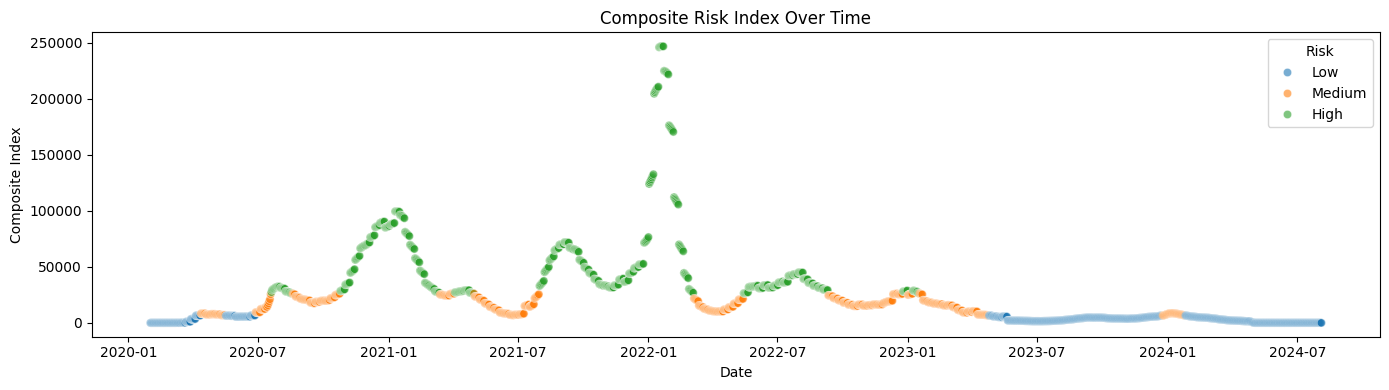

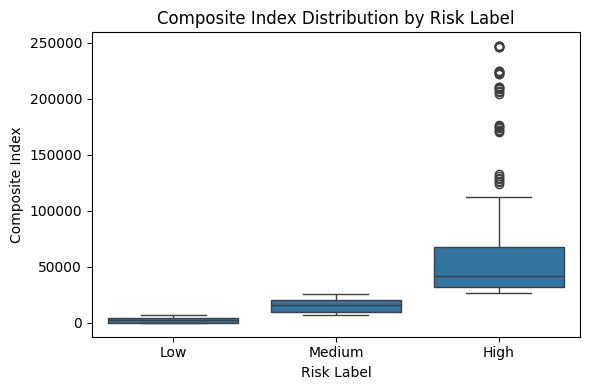

/var/folders/b9/z4ks52n911g9q1n4r04_b8gr0000gn/T/ipykernel_7911/1126365485.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = us.groupby(['month','risk_label']).size().unstack(fill_value=0)


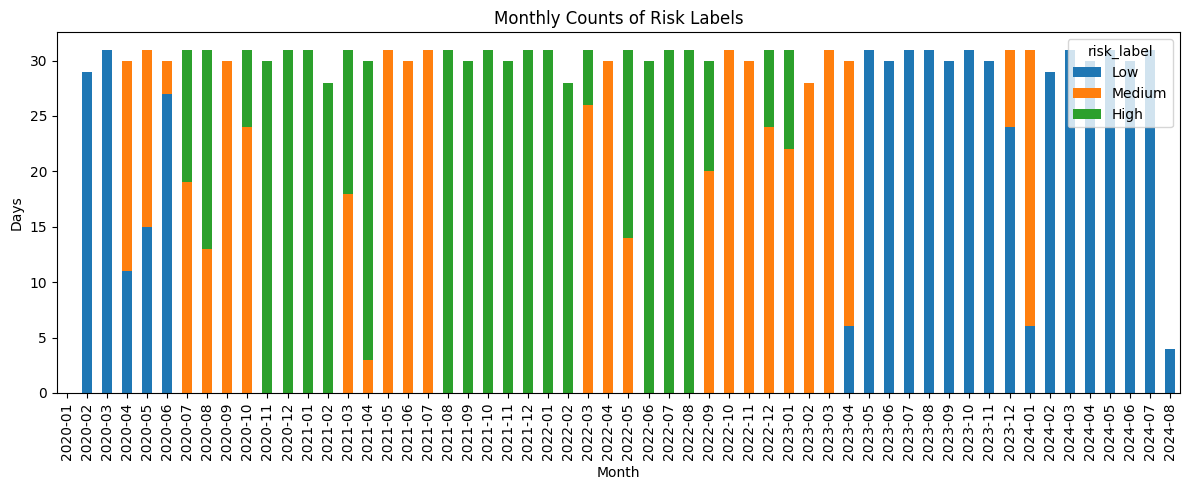

In [27]:
# A) Composite index over time colored by label
plt.figure(figsize=(14,4))
sns.scatterplot(
    data=us.dropna(subset=['composite_index']),
    x='date', y='composite_index',
    hue='risk_label', alpha=0.6
)
plt.title('Composite Risk Index Over Time')
plt.xlabel('Date'); plt.ylabel('Composite Index')
plt.legend(title='Risk'); plt.tight_layout(); plt.show()

# B) Boxplot of composite_index by risk_label
plt.figure(figsize=(6,4))
sns.boxplot(x='risk_label', y='composite_index', data=us)
plt.title('Composite Index Distribution by Risk Label')
plt.xlabel('Risk Label'); plt.ylabel('Composite Index')
plt.tight_layout(); plt.show()

# C) Monthly counts of labels
us['month'] = us['date'].dt.to_period('M')
counts = us.groupby(['month','risk_label']).size().unstack(fill_value=0)
counts.plot(kind='bar', stacked=True, figsize=(12,5))
plt.title('Monthly Counts of Risk Labels')
plt.xlabel('Month'); plt.ylabel('Days')
plt.tight_layout(); plt.show()


### Key Findings Summary

🔹 Alignment with Epidemic Waves
The “High” risk label consistently corresponds to known COVID‑19 surges (April 2020, January 2021, Omicron in early 2022), while “Low” labels cluster in the initial pre‑wave period and between waves. “Medium” fills the transitional ramp‑up and decline phases.

🔹 Clear Statistical Separation
Boxplots of the composite risk index show minimal overlap between Low, Medium, and High categories: each label occupies a distinct range of index values, confirming that the quantile cut‑points produce well‑separated risk groups.

🔹 Monthly Trends Reflect Reality
Stacked‑bar counts by month reveal that:

-Early 2020 months are almost entirely Low.

-Spring 2020 and winter 2020–21 are dominated by High days.

-Summer 2020 and mid‑2021 (Delta wave) show more Medium days.

-Post‑Omicron periods revert to predominantly Low/Medium.

🔹 Validation Confidence
Together, the time‑series scatter, distribution boxplots, and monthly counts demonstrate that the engineered composite index and quantile‑based labeling reliably capture the pandemic’s ups and downs. These labels are both interpretable and actionable, making them strong targets for downstream classification models.

In [28]:
# 8. Save the final engineered dataset & labels
us.to_csv('../data/us_covid_features_and_labels_cleaned.csv', index=False)
print("Saved us_covid_features_and_labels_cleaned.csv")


Saved us_covid_features_and_labels_cleaned.csv
